<a href="https://colab.research.google.com/github/gve0456/Emotion-Detection-and-Music-Recommended-system/blob/main/emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import cv2
import numpy as np
import kagglehub
import zipfile
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

In [ ]:
print("Downloading FER-2013 dataset from Kaggle...")
path = kagglehub.dataset_download("msambare/fer2013")

zip_path = os.path.join(path, "fer2013.zip")
if os.path.exists(zip_path):
    print("Extracting zip file...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(path)
else:
    print("Zip file not found, assuming data is already extracted.")

train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')
print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

Zip file not found, assuming data is already extracted.
Train directory: /kaggle/input/fer2013/train
Test directory: /kaggle/input/fer2013/test


In [ ]:
IMG_HEIGHT = 48
IMG_WIDTH = 48

emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}

def load_data_from_folders(directory):
    """
    Loads images and labels from a directory structured with emotion subfolders.
    """
    images = []
    labels = []
    print(f"Loading data from {directory}...")
    for emotion_folder, label in emotion_labels.items():
        folder_path = os.path.join(directory, emotion_folder)
        if not os.path.isdir(folder_path):
            continue
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:

                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                img = img / 255.0
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
# Assuming `train_dir` and `test_dir` are defined from previous steps
X_train, y_train = load_data_from_folders(train_dir)
X_test, y_test = load_data_from_folders(test_dir)


print("\nSplitting the test set into validation and final test sets...")
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)


X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

print("\nData processing complete.")
print(f"Training set shape:   X={X_train.shape}, y={y_train.shape}")
print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
print(f"Test set shape:       X={X_test.shape}, y={y_test.shape}")

Loading data from /kaggle/input/fer2013/train...
Loading data from /kaggle/input/fer2013/test...

Splitting the test set into validation and final test sets...

Data processing complete.
Training set shape:   X=(28709, 48, 48, 1), y=(28709,)
Validation set shape: X=(3589, 48, 48, 1), y=(3589,)
Test set shape:       X=(3589, 48, 48, 1), y=(3589,)


In [ ]:
# Convert integer labels (0 to 6) to one-hot vectors (e.g., 3 -> [0, 0, 0, 1, 0, 0, 0])
NUM_CLASSES = len(emotion_labels) # 7
y_train_encoded = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_encoded = to_categorical(y_val, num_classes=NUM_CLASSES)
y_test_encoded = to_categorical(y_test, num_classes=NUM_CLASSES)

print(f"Labels shape after encoding: {y_train_encoded.shape}")

Labels shape after encoding: (28709, 7)


In [ ]:

X_train, y_train = load_data_from_folders(train_dir)
X_test, y_test = load_data_from_folders(test_dir)


print("\nSplitting the test set into validation and final test sets...")
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)


X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

print("\nData processing complete.")
print(f"Training set shape:   X={X_train.shape}, y={y_train.shape}")
print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
print(f"Test set shape:       X={X_test.shape}, y={y_test.shape}")

Loading data from /kaggle/input/fer2013/train...
Loading data from /kaggle/input/fer2013/test...

Splitting the test set into validation and final test sets...

Data processing complete.
Training set shape:   X=(28709, 48, 48, 1), y=(28709,)
Validation set shape: X=(3589, 48, 48, 1), y=(3589,)
Test set shape:       X=(3589, 48, 48, 1), y=(3589,)


In [ ]:

output_dir = './processed_fer_data'
os.makedirs(output_dir, exist_ok=True)
print(f"\nSaving processed data to '{output_dir}' directory...")

np.save(os.path.join(output_dir, 'X_train.npy'), X_train)
np.save(os.path.join(output_dir, 'y_train.npy'), y_train)
np.save(os.path.join(output_dir, 'X_val.npy'), X_val)
np.save(os.path.join(output_dir, 'y_val.npy'), y_val)
np.save(os.path.join(output_dir, 'X_test.npy'), X_test)
np.save(os.path.join(output_dir, 'y_test.npy'), y_test)

print(f"\nAll files saved successfully!")


Saving processed data to './processed_fer_data' directory...

All files saved successfully!


In [ ]:
drive_output_dir = '/content/drive/MyDrive/MoodMate_Project/processed_fer_data'
os.makedirs(drive_output_dir, exist_ok=True)
print(f"\nSaving processed data to Google Drive: '{drive_output_dir}'")

local_output_dir = './processed_fer_data'
X_train = np.load(os.path.join(local_output_dir, 'X_train.npy'))
y_train = np.load(os.path.join(local_output_dir, 'y_train.npy'))
X_val = np.load(os.path.join(local_output_dir, 'X_val.npy'))
y_val = np.load(os.path.join(local_output_dir, 'y_val.npy'))
X_test = np.load(os.path.join(local_output_dir, 'X_test.npy'))
y_test = np.load(os.path.join(local_output_dir, 'y_test.npy'))


# Convert integer labels (0 to 6) to one-hot vectors (e.g., 3 -> [0, 0, 0, 1, 0, 0, 0])
NUM_CLASSES = len(emotion_labels) # 7
y_train_encoded = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_encoded = to_categorical(y_val, num_classes=NUM_CLASSES)
y_test_encoded = to_categorical(y_test, num_classes=NUM_CLASSES)

print(f"Labels shape after encoding: {y_train_encoded.shape}")

# y_train, y_val, and y_test are currently integer labels (0, 1, 2, etc.).

NUM_CLASSES = len(emotion_labels)
y_train_encoded = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_encoded = to_categorical(y_val, num_classes=NUM_CLASSES)
y_test_encoded = to_categorical(y_test, num_classes=NUM_CLASSES)

print(f"\nLabels shape after encoding: {y_train_encoded.shape}")


np.save(os.path.join(drive_output_dir, 'X_train.npy'), X_train)
np.save(os.path.join(drive_output_dir, 'y_train.npy'), y_train)
np.save(os.path.join(drive_output_dir, 'X_val.npy'), X_val)
np.save(os.path.join(drive_output_dir, 'y_val.npy'), y_val)
np.save(os.path.join(drive_output_dir, 'X_test.npy'), X_test)
np.save(os.path.join(drive_output_dir, 'y_test.npy'), y_test)

print(f"\n All files saved successfully to your Google Drive!")


Saving processed data to Google Drive: '/content/drive/MyDrive/MoodMate_Project/processed_fer_data'
Labels shape after encoding: (28709, 7)

Labels shape after encoding: (28709, 7)

 All files saved successfully to your Google Drive!


In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,847 (1.36 MB)

 Trainable params: 355,847 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
epochs = 50
batch_size = 64

history = model.fit(
    X_train, y_train_encoded,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val_encoded)
)

Epoch 1/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.2515 - loss: 1.8165 - val_accuracy: 0.3653 - val_loss: 1.6029
Epoch 2/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3832 - loss: 1.5693 - val_accuracy: 0.4667 - val_loss: 1.4188
Epoch 3/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4599 - loss: 1.4096 - val_accuracy: 0.4987 - val_loss: 1.3173
Epoch 4/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4890 - loss: 1.3423 - val_accuracy: 0.5266 - val_loss: 1.2587
Epoch 5/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5088 - loss: 1.2832 - val_accuracy: 0.5352 - val_loss: 1.2219
Epoch 6/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5349 - loss: 1.2259 - val_accuracy: 0.5458 - val_loss: 1.2009
Epoch 7/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5527 - loss: 1.1891 - val_accuracy: 0.5631 - val_loss: 1.1649
Epoch 8/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5676 - loss: 1.1428 - val_accuracy:

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5636 - loss: 1.1898
Test Loss: 1.1850
Test Accuracy: 0.5606


In [ ]:
# Save the trained model
model_save_path = '/content/drive/MyDrive/MoodMate_Project/emotion_detection_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/MoodMate_Project/emotion_detection_model.h5


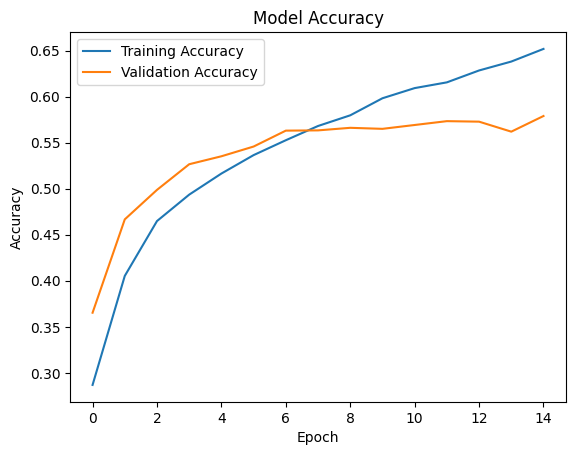

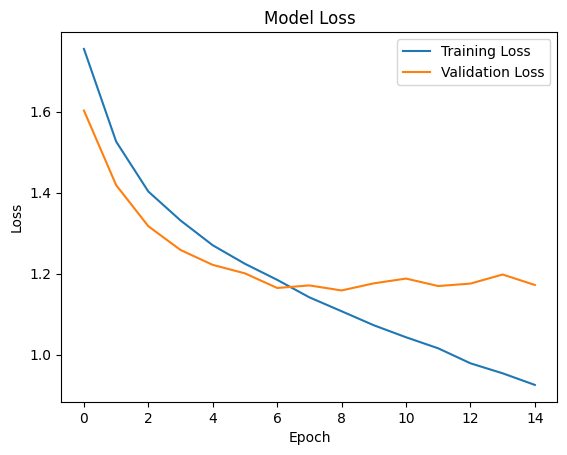

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model(model_save_path)

# Evaluate the loaded model on the test set
loss, accuracy = loaded_model.evaluate(X_test, y_test_encoded)
print(f"Loaded Model Test Loss: {loss:.4f}")
print(f"Loaded Model Test Accuracy: {accuracy:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5636 - loss: 1.1898
Loaded Model Test Loss: 1.1850
Loaded Model Test Accuracy: 0.5606


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# ResNet50 expects 3-channel input, so repeat grayscale channel
X_train_resnet = np.repeat(X_train, 3, axis=-1)
X_val_resnet   = np.repeat(X_val, 3, axis=-1)
X_test_resnet  = np.repeat(X_test, 3, axis=-1)

print(f"ResNet-ready training set: {X_train_resnet.shape}")

# Define input shape for ResNet50
input_shape = (48, 48, 3)

# Load ResNet50 base (without top classifier)
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

# Freeze base layers so only new layers train first
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()

# Train
history = model.fit(
    X_train_resnet, y_train_encoded,
    validation_data=(X_val_resnet, y_val_encoded),
    epochs=20,
    batch_size=64
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test_resnet, y_test_encoded, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}")


ResNet-ready training set: (28709, 48, 48, 3)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 24, 24,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 24, 24,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_66']
Received: inputs=Tensor(shape=(None, 48, 48, 3))
  warnings.warn(msg)


449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.2153 - loss: 1.9278 - val_accuracy: 0.2533 - val_loss: 1.7939
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.2441 - loss: 1.8062 - val_accuracy: 0.2678 - val_loss: 1.7856
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.2531 - loss: 1.7962 - val_accuracy: 0.2697 - val_loss: 1.7752
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2594 - loss: 1.7867 - val_accuracy: 0.2569 - val_loss: 1.7643
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.2714 - loss: 1.7717 - val_accuracy: 0.2758 - val_loss: 1.7571
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.2730 - loss: 1.7672 - val_accuracy: 0.2914 - val_loss: 1.7515
Epoch 7/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2718 - loss: 1.7595 - val_accuracy: 0.2959 - val_loss: 1.7476
Epoch 8/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.2866 - loss: 1.7510 - val_accuracy: 0.29

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,847 (1.36 MB)

 Trainable params: 355,847 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.2446 - loss: 1.8175 - val_accuracy: 0.4138 - val_loss: 1.5492
Epoch 2/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4005 - loss: 1.5478 - val_accuracy: 0.4695 - val_loss: 1.3982
Epoch 3/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4654 - loss: 1.4073 - val_accuracy: 0.5001 - val_loss: 1.3165
Epoch 4/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5018 - loss: 1.3167 - val_accuracy: 0.5065 - val_loss: 1.2900
Epoch 5/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5249 - loss: 1.2592 - val_accuracy: 0.5425 - val_loss: 1.2119
Epoch 6/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5517 - loss: 1.1969 - val_accuracy: 0.5531 - val_loss: 1.1904
Epoch 7/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5646 - loss: 1.1568 - val_accuracy: 0.5570 - val_loss: 1.1811
Epoch 8/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5771 - loss: 1.1179 - val_accuracy: 0

CNN Test Loss: 1.1916  Test Accuracy: 0.5606
CNN model saved to: /content/drive/MyDrive/MoodMate_Project/emotion_detection_cnn.h5


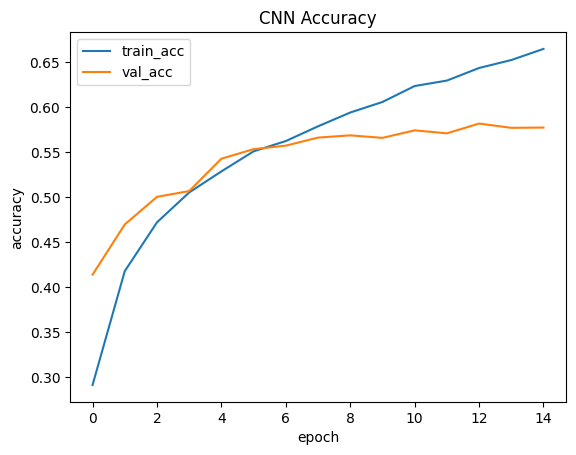

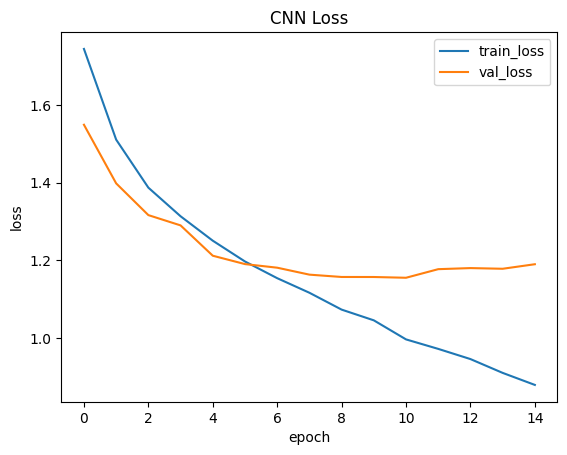

Converting grayscale arrays to RGB for ResNet50...
RGB shapes: (28709, 48, 48, 3) (3589, 48, 48, 3) (3589, 48, 48, 3)


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 24, 24,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 24, 24,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,887 (90.98 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

KeyboardInterrupt: 

In [ ]:
# Define epochs and batch size
EPOCHS_CNN = 15
BATCH_SIZE = 64
EPOCHS_RESNET_TOP = 10
FINE_TUNE_EPOCHS = 10

# 10) Build and train a simple CNN (grayscale input)
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

history_cnn = cnn_model.fit(
    X_train, y_train_encoded,
    epochs=EPOCHS_CNN,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val_encoded)
)

# Evaluate and save
loss_cnn, acc_cnn = cnn_model.evaluate(X_test, y_test_encoded)
print(f"CNN Test Loss: {loss_cnn:.4f}  Test Accuracy: {acc_cnn:.4f}")

cnn_save_path = '/content/drive/MyDrive/MoodMate_Project/emotion_detection_cnn.h5'
cnn_model.save(cnn_save_path)
print("CNN model saved to:", cnn_save_path)

# Plot training curves (accuracy and loss)
plt.figure()
plt.plot(history_cnn.history['accuracy'], label='train_acc')
plt.plot(history_cnn.history['val_accuracy'], label='val_acc')
plt.title('CNN Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_cnn.history['loss'], label='train_loss')
plt.plot(history_cnn.history['val_loss'], label='val_loss')
plt.title('CNN Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


# 11) Prepare data for ResNet50 (convert grayscale -> 3 channels)
def to_rgb_from_grayscale(X_gray):
    # X_gray shape: (N, H, W, 1)
    # use tensorflow op for correct dtype/shape
    X_tf = tf.convert_to_tensor(X_gray, dtype=tf.float32)
    X_rgb = tf.image.grayscale_to_rgb(X_tf)  # returns (N, H, W, 3)
    return X_rgb.numpy()

print("Converting grayscale arrays to RGB for ResNet50...")
X_train_rgb = to_rgb_from_grayscale(X_train)
X_val_rgb   = to_rgb_from_grayscale(X_val)
X_test_rgb  = to_rgb_from_grayscale(X_test)
print("RGB shapes:", X_train_rgb.shape, X_val_rgb.shape, X_test_rgb.shape)

# Optionally: If you want to use ImageNet preprocessing (ResNet50 expects inputs scaled similarly),
# you can use tf.keras.applications.resnet.preprocess_input. Here images are already [0,1], convert to [-1,1].
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
X_train_rgb = resnet_preprocess(X_train_rgb * 255.0)
X_val_rgb   = resnet_preprocess(X_val_rgb * 255.0)
X_test_rgb  = resnet_preprocess(X_test_rgb * 255.0)

# 12) Build ResNet50-based model (top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=predictions)
resnet_model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

history_resnet_top = resnet_model.fit(
    X_train_rgb, y_train_encoded,
    epochs=EPOCHS_RESNET_TOP,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_rgb, y_val_encoded)
)

# Evaluate and save
loss_resnet, acc_resnet = resnet_model.evaluate(X_test_rgb, y_test_encoded)
print(f"ResNet (top) Test Loss: {loss_resnet:.4f}  Test Accuracy: {acc_resnet:.4f}")

resnet_save_path = '/content/drive/MyDrive/MoodMate_Project/emotion_detection_resnet_top.h5'
resnet_model.save(resnet_save_path)
print("ResNet (top) model saved to:", resnet_save_path)

# Plot training curves for ResNet top layers
plt.figure()
plt.plot(history_resnet_top.history['accuracy'], label='train_acc_resnet_top')
plt.plot(history_resnet_top.history['val_accuracy'], label='val_acc_resnet_top')
plt.title('ResNet Top Layers Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_resnet_top.history['loss'], label='train_loss_resnet_top')
plt.plot(history_resnet_top.history['val_loss'], label='val_loss_resnet_top')
plt.title('ResNet Top Layers Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


# 13) Fine-tune: unfreeze some of the top base_model layers and train with a low LR
print("Starting fine-tuning: unfreezing the top layers of the base ResNet50...")

# Unfreeze the top layers of the base model (e.g., last 10 layers). Adjust as needed.
base_model.trainable = True

# Freeze lower layers if you want to only fine-tune last N layers example:
fine_tune_at = -20  # unfreeze last 20 layers; negative indexing used to be simple; adjust per your need
if fine_tune_at < 0:
    # find layer index to freeze up to
    total_layers = len(base_model.layers)
    freeze_until = max(0, total_layers + fine_tune_at)
else:
    freeze_until = fine_tune_at

for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= freeze_until

resnet_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = resnet_model.fit(
    X_train_rgb, y_train_encoded,
    epochs=EPOCHS_RESNET_TOP + FINE_TUNE_EPOCHS,
    initial_epoch=history_resnet_top.epoch[-1] if hasattr(history_resnet_top, 'epoch') and len(history_resnet_top.epoch) > 0 else 0,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_rgb, y_val_encoded)
)

loss_ft, acc_ft = resnet_model.evaluate(X_test_rgb, y_test_encoded)
print(f"Fine-tuned ResNet Test Loss: {loss_ft:.4f}  Test Accuracy: {acc_ft:.4f}")

final_resnet_path = '/content/drive/MyDrive/MoodMate_Project/emotion_detection_resnet_finetuned.h5'
resnet_model.save(final_resnet_path)
print("Fine-tuned ResNet model saved to:", final_resnet_path)

# Plot training curves for ResNet fine-tuning
plt.figure()
plt.plot(history_finetune.history['accuracy'], label='train_acc_resnet_finetune')
plt.plot(history_finetune.history['val_accuracy'], label='val_acc_resnet_finetune')
plt.title('ResNet Fine-tuned Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_finetune.history['loss'], label='train_loss_resnet_finetune')
plt.plot(history_finetune.history['val_loss'], label='val_loss_resnet_finetune')
plt.title('ResNet Fine-tuned Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
--- CNN Model Evaluation ---

Classification Report:
              precision    recall  f1-score   support

       angry       0.45      0.56      0.50       479
     disgust       0.91      0.18      0.30        56
        fear       0.40      0.35      0.37       512
       happy       0.79      0.76      0.77       887
     neutral       0.53      0.46      0.50       616
         sad       0.40      0.50      0.45       624
    surprise       0.76      0.68      0.72       415

    accuracy                           0.56      3589
   macro avg       0.61      0.50      0.52      3589
weighted avg       0.58      0.56      0.56      3589


Confusion Matrix:


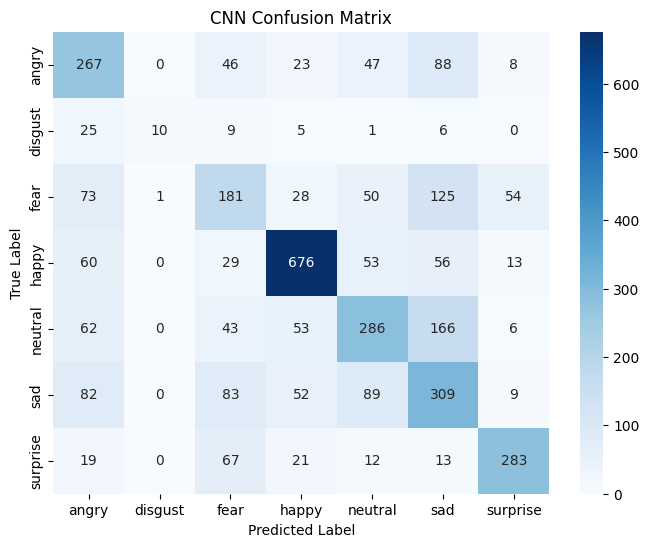

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step

--- Fine-tuned ResNet Model Evaluation ---

Classification Report:
              precision    recall  f1-score   support

       angry       0.17      0.04      0.06       479
     disgust       0.00      0.00      0.00        56
        fear       0.23      0.04      0.06       512
       happy       0.16      0.07      0.10       887
     neutral       0.18      0.41      0.25       616
         sad       0.18      0.46      0.26       624
    surprise       0.36      0.01      0.02       415

    accuracy                           0.18      3589
   macro avg       0.18      0.15      0.11      3589
weighted avg       0.20      0.18      0.13      3589


Confusion Matrix:


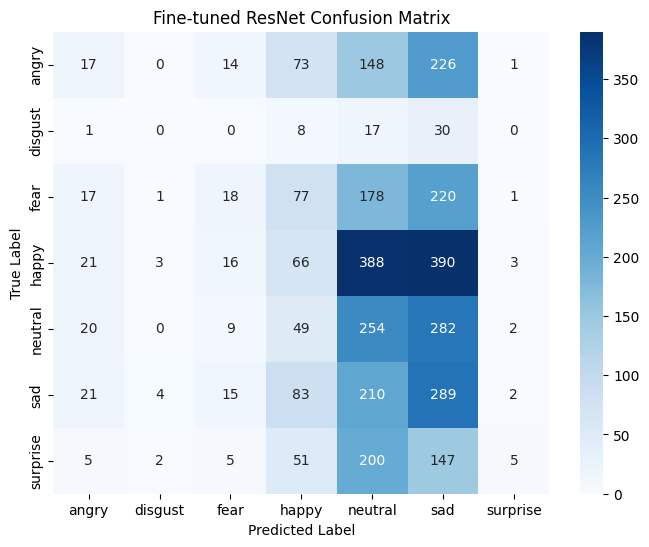

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_encoded and emotion_labels are available from previous steps
# emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
emotion_names = list(emotion_labels.keys())

# Evaluate the CNN model
cnn_predictions = cnn_model.predict(X_test)
cnn_predicted_classes = np.argmax(cnn_predictions, axis=1)
cnn_true_classes = np.argmax(y_test_encoded, axis=1)

print("--- CNN Model Evaluation ---")
print("\nClassification Report:")
print(classification_report(cnn_true_classes, cnn_predicted_classes, target_names=emotion_names))

print("\nConfusion Matrix:")
cm_cnn = confusion_matrix(cnn_true_classes, cnn_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_names, yticklabels=emotion_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN Confusion Matrix')
plt.show()

# Evaluate the Fine-tuned ResNet model
resnet_predictions = resnet_model.predict(X_test_rgb)
resnet_predicted_classes = np.argmax(resnet_predictions, axis=1)
resnet_true_classes = np.argmax(y_test_encoded, axis=1) # Assuming y_test_encoded is the same for both

print("\n--- Fine-tuned ResNet Model Evaluation ---")
print("\nClassification Report:")
print(classification_report(resnet_true_classes, resnet_predicted_classes, target_names=emotion_names))

print("\nConfusion Matrix:")
cm_resnet = confusion_matrix(resnet_true_classes, resnet_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_names, yticklabels=emotion_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Fine-tuned ResNet Confusion Matrix')
plt.show()